/tmp/ipython-input-3407867276.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='REACTION', data=df, palette='viridis')


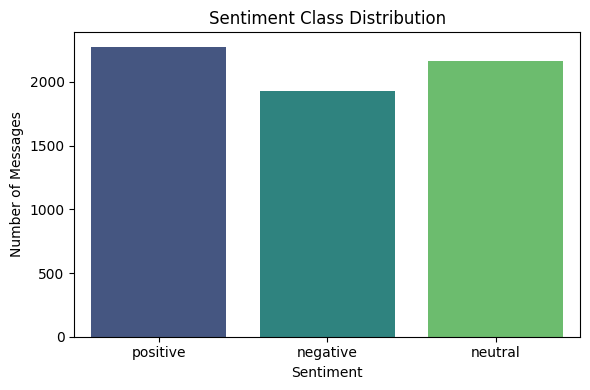

In [3]:
# =============================
# 📊 Sentiment Class Distribution
# =============================
plt.figure(figsize=(6,4))
sns.countplot(x='REACTION', data=df, palette='viridis')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Messages")
plt.tight_layout()
plt.show()


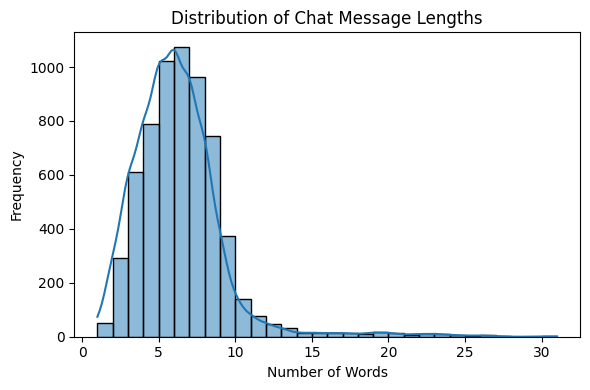

In [4]:
# =============================
# 🧾 Message Length Distribution
# =============================
df['text_length'] = df['TEXT'].apply(lambda x: len(x.split()))

plt.figure(figsize=(6,4))
sns.histplot(df['text_length'], bins=30, kde=True)
plt.title("Distribution of Chat Message Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


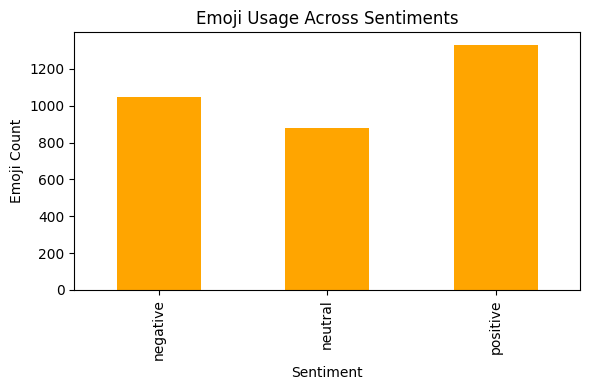

In [5]:
# =============================
# 😊 Emoji Presence Analysis
# =============================
df['has_emoji'] = df['TEXT'].apply(lambda x: ':' in x)

emoji_counts = df.groupby('REACTION')['has_emoji'].sum()

plt.figure(figsize=(6,4))
emoji_counts.plot(kind='bar', color='orange')
plt.title("Emoji Usage Across Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Emoji Count")
plt.tight_layout()
plt.show()


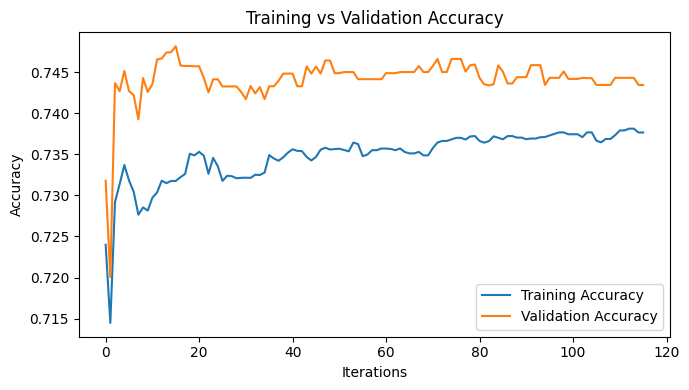

In [6]:
# =============================
# 📉 Training vs Validation Accuracy
# =============================
evals_result = model.get_evals_result()

plt.figure(figsize=(7,4))
plt.plot(evals_result['learn']['Accuracy'], label='Training Accuracy')
plt.plot(evals_result['validation']['Accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


Class Distribution:
 REACTION
positive    2275
neutral     2160
negative    1925
Name: count, dtype: int64
0:	learn: 0.7239953	test: 0.7317823	best: 0.7317823 (0)	total: 1.69s	remaining: 56m 21s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.7481427519
bestIteration = 15

Shrink model to first 16 iterations.

✅ Accuracy: 74.69 %

📋 Classification Report:

              precision    recall  f1-score   support

    negative       0.81      0.76      0.78       385
     neutral       0.64      0.78      0.70       432
    positive       0.84      0.70      0.76       455

    accuracy                           0.75      1272
   macro avg       0.76      0.75      0.75      1272
weighted avg       0.76      0.75      0.75      1272



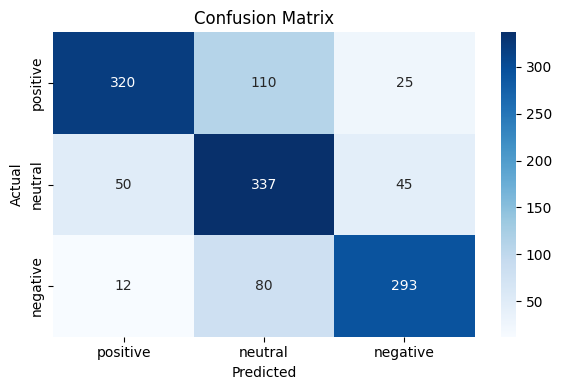

In [2]:
# =============================
# 📦 Install Packages
# =============================
!pip install -q catboost emoji

# =============================
# 🔽 Import Libraries
# =============================
import pandas as pd
import re
import emoji
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# 📥 Load Dataset
# =============================
df = pd.read_csv("/content/DATASET.csv")

# Drop missing / duplicate rows
df.dropna(subset=['TEXT', 'REACTION'], inplace=True)
df.drop_duplicates(subset=['TEXT', 'REACTION'], inplace=True)

# Normalize labels
df['REACTION'] = df['REACTION'].str.lower().str.strip()
df = df[df['REACTION'].isin(['positive', 'negative', 'neutral'])]

# =============================
# 🧹 Text Cleaning
# =============================
def clean_text(text):
    text = str(text).lower()
    text = emoji.demojize(text)                        # 😊 -> :smile:
    text = re.sub(r"http\S+", "", text)                # remove links
    text = re.sub(r"[^a-zA-Z\s:]", "", text)           # keep emoji tokens
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)         # normalize repeats
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['TEXT'] = df['TEXT'].apply(clean_text)

# =============================
# 🔖 Label Encoding
# =============================
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['REACTION'])

# =============================
# 🧪 Train-Test Split
# =============================
X = df[['TEXT']]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# =============================
# 📊 Class Balance
# =============================
print("Class Distribution:\n", df['REACTION'].value_counts())

# Get class weights (inverse frequency)
class_counts = df['label'].value_counts().to_dict()
total = len(df)
class_weights = {cls: total/count for cls, count in class_counts.items()}

# =============================
# 🧠 CatBoost Pool
# =============================
train_pool = Pool(data=X_train, label=y_train, text_features=['TEXT'])
test_pool = Pool(data=X_test, label=y_test, text_features=['TEXT'])

# =============================
# 🚀 Train CatBoost
# =============================
model = CatBoostClassifier(
    iterations=2000,
    depth=8,
    learning_rate=0.04,
    l2_leaf_reg=3,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    early_stopping_rounds=100,
    class_weights=class_weights,
    random_seed=42,
    verbose=200
)

model.fit(train_pool, eval_set=test_pool)

# =============================
# ✅ Evaluation
# =============================
y_pred = model.predict(test_pool).reshape(-1)
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)

print("\n✅ Accuracy:", round(accuracy_score(y_test_labels, y_pred_labels) * 100, 2), "%")
print("\n📋 Classification Report:\n")
print(classification_report(y_test_labels, y_pred_labels))

# =============================
# 📊 Confusion Matrix
# =============================
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=['positive','neutral','negative'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive','neutral','negative'],
            yticklabels=['positive','neutral','negative'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# =============================
# 💾 Save Model
# =============================
# model.save_model("catboost_sentiment_model.cbm")
# df.to_csv("cleaned_sentiment_dataset.csv", index=False)
